In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

In [17]:
df = pd.read_csv('data/train_iterative_imputer_cloud_coverage.csv')
df

,wind_direction,building_id,timestamp,meter_reading,primary_use,square_feet,year_built,cloud_coverage,air_temperature,dew_temperature,sea_level_pressure,wind_speed,hour,month,precip_depth_1_hr
0,0.0,1,2016-01-01 00:00:00,0.0000,Education,2720,2004,6.000000,25.0,20.0,1019.7,0.0,0.0,1.0,0.720905
1,0.0,2,2016-01-01 00:00:00,0.0000,Education,5376,1991,6.000000,25.0,20.0,1019.7,0.0,0.0,1.0,0.720905
2,0.0,3,2016-01-01 00:00:00,0.0000,Education,23685,2002,6.000000,25.0,20.0,1019.7,0.0,0.0,1.0,0.720905
3,0.0,4,2016-01-01 00:00:00,0.0000,Education,116607,1975,6.000000,25.0,20.0,1019.7,0.0,0.0,1.0,0.720905
4,0.0,5,2016-01-01 00:00:00,0.0000,Education,8000,2000,6.000000,25.0,20.0,1019.7,0.0,0.0,1.0,0.720905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698670,0.0,96,2016-12-31 23:00:00,414.1430,Lodging/residential,200933,2006,2.910058,20.6,10.0,1021.1,0.0,23.0,12.0,0.000000
698671,0.0,97,2016-12-31 23:00:00,420.6280,Lodging/residential,187647,2007,2.910058,20.6,10.0,1021.1,0.0,23.0,12.0,0.000000
698672,0.0,98,2016-12-31 23:00:00,409.3650,Lodging/residential,200933,2007,2.910058,20.6,10.0,1021.1,0.0,23.0,12.0,0.000000
698673,0.0,99,2016-12-31 23:00:00,8.7504,Office,2260,2016,2.910058,20.6,10.0,1021.1,0.0,23.0,12.0,0.000000


Data shape: (698675, 15)

Numeric columns:
['wind_direction', 'building_id', 'meter_reading', 'square_feet', 'year_built', 'cloud_coverage', 'air_temperature', 'dew_temperature', 'sea_level_pressure', 'wind_speed', 'hour', 'month', 'precip_depth_1_hr']

Categorical columns:
['primary_use']


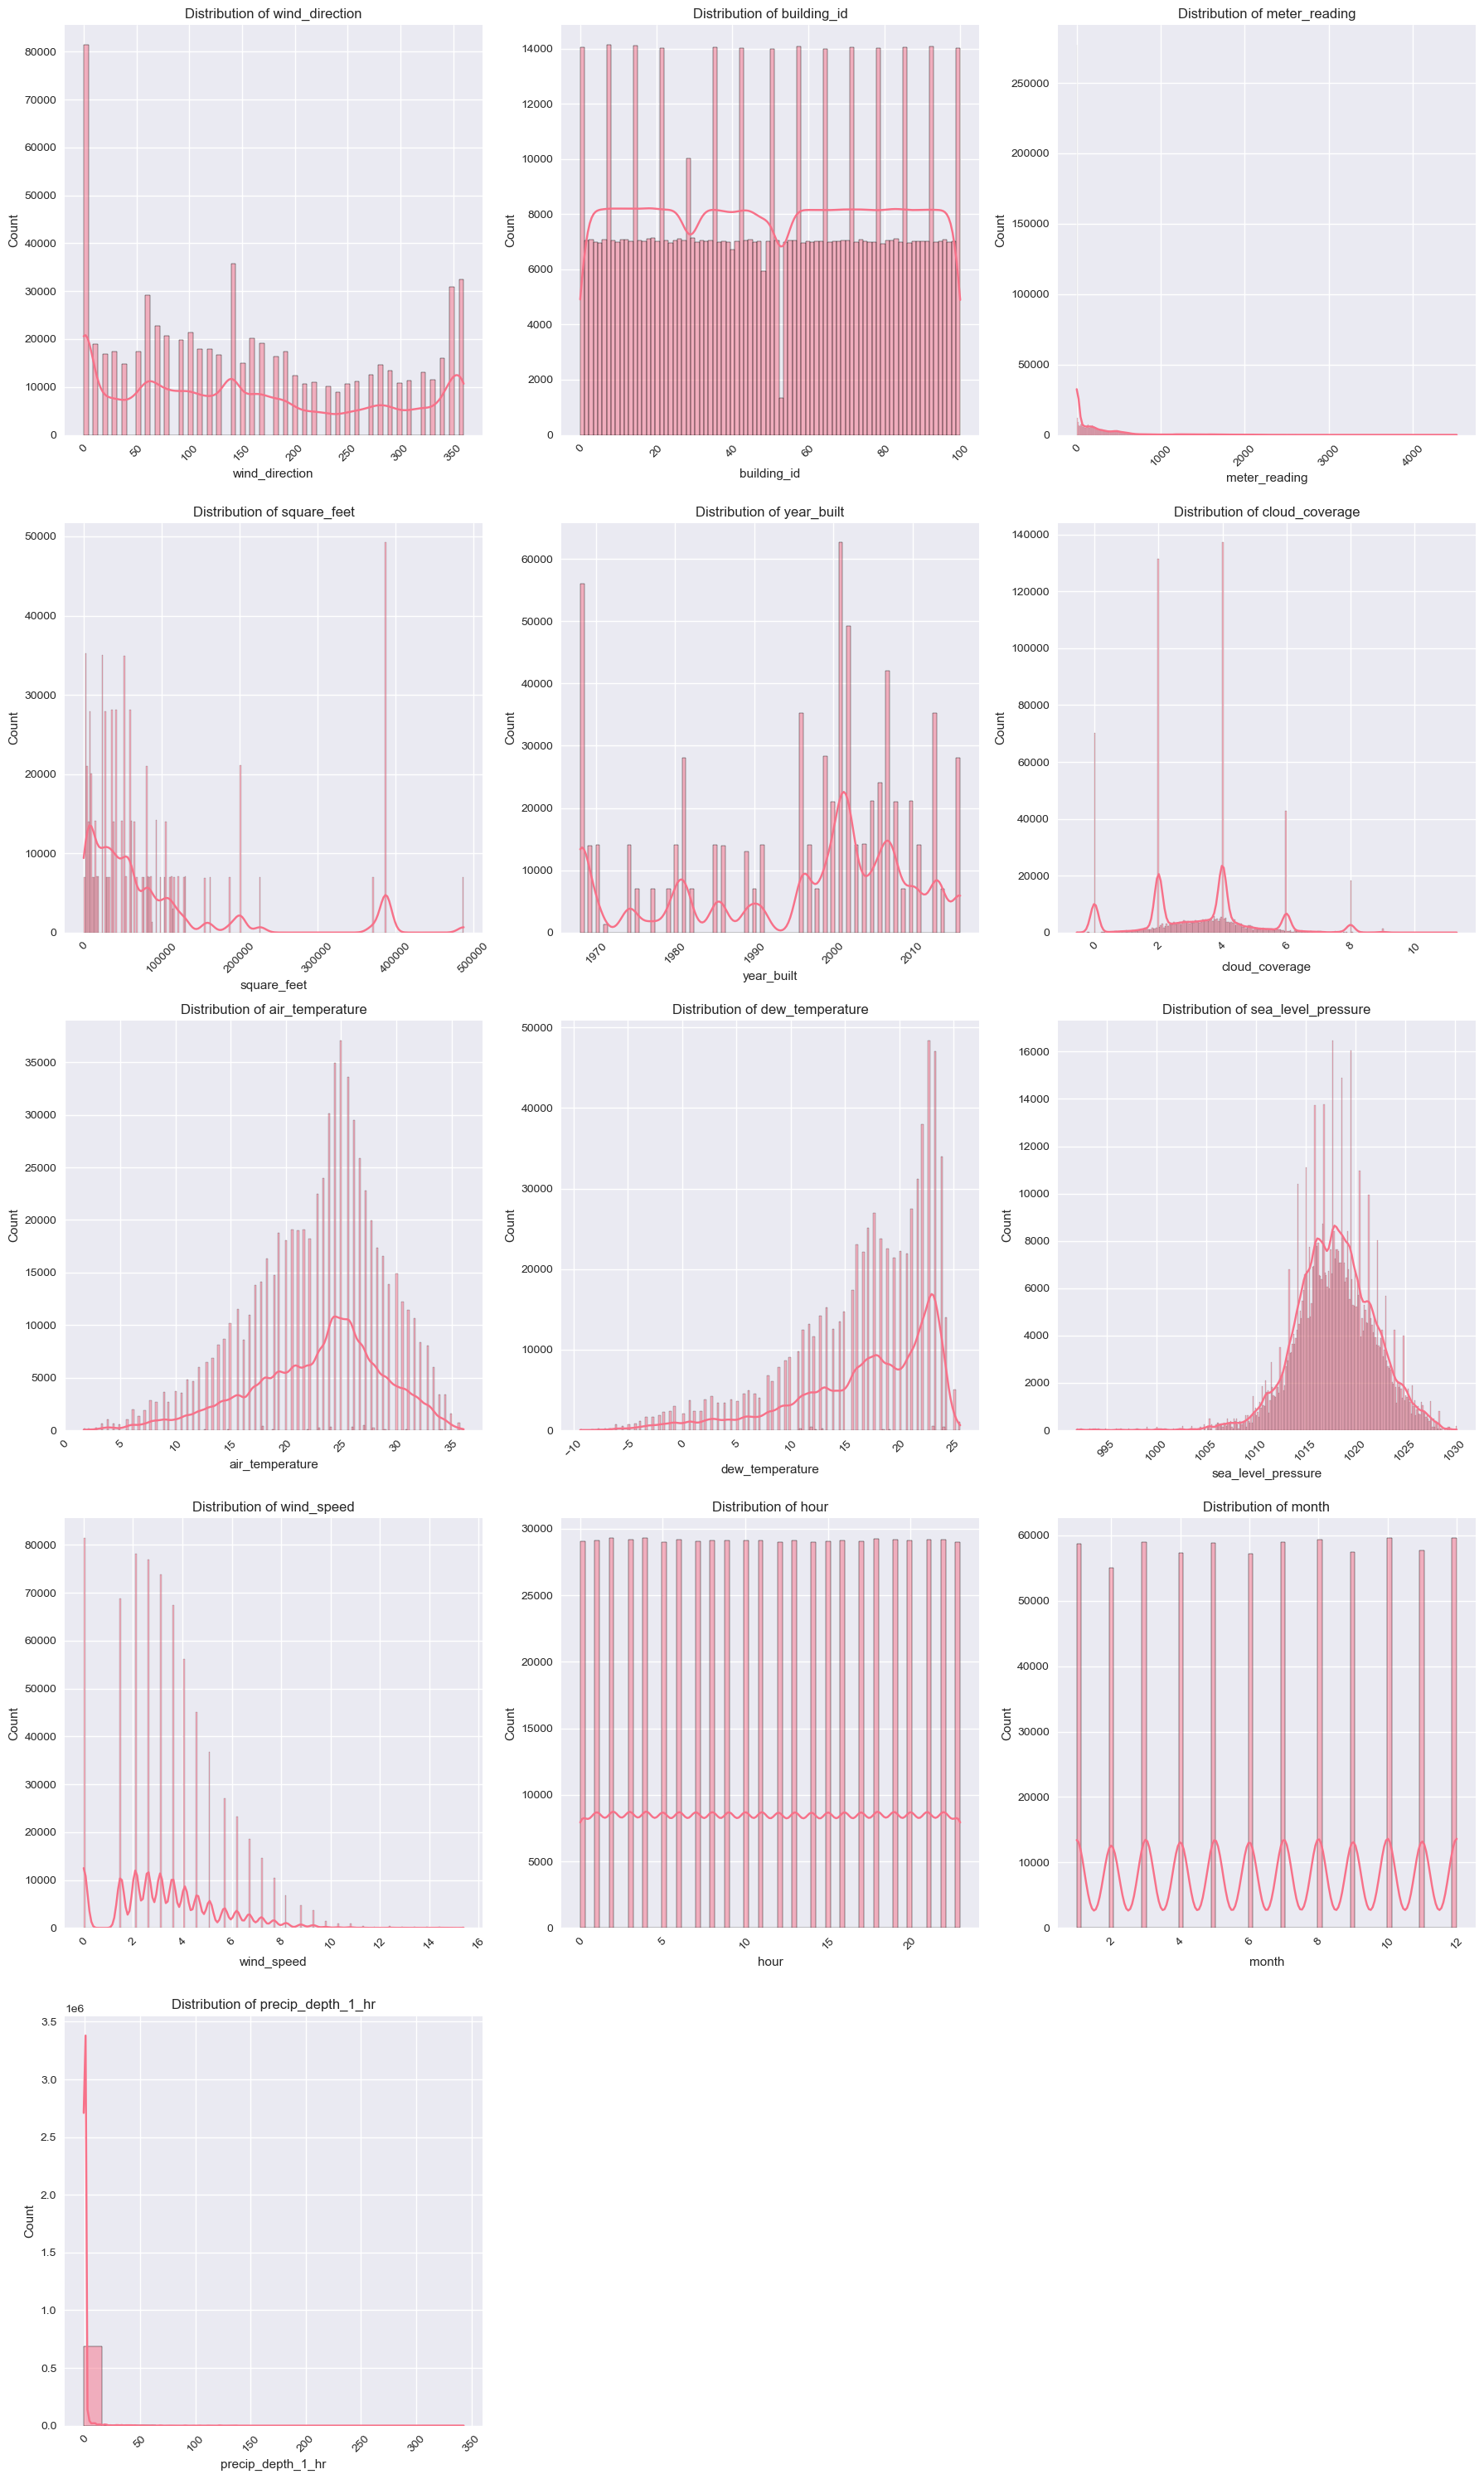

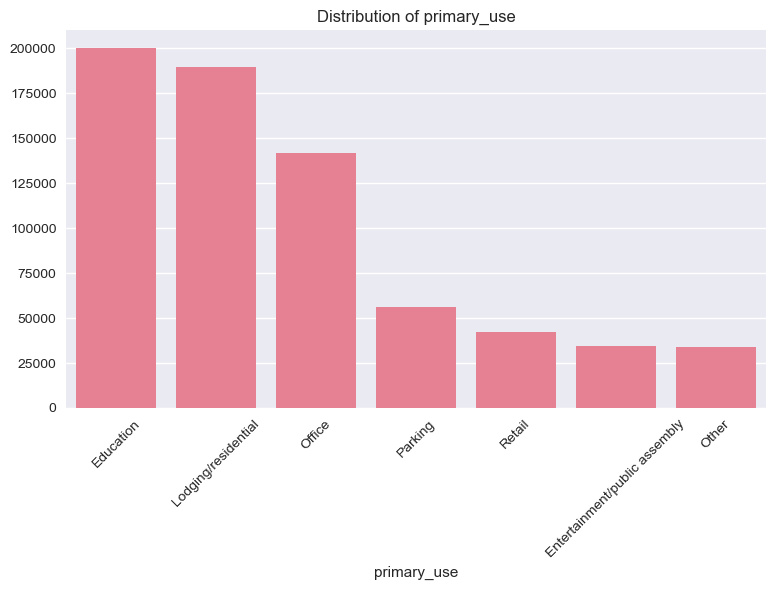

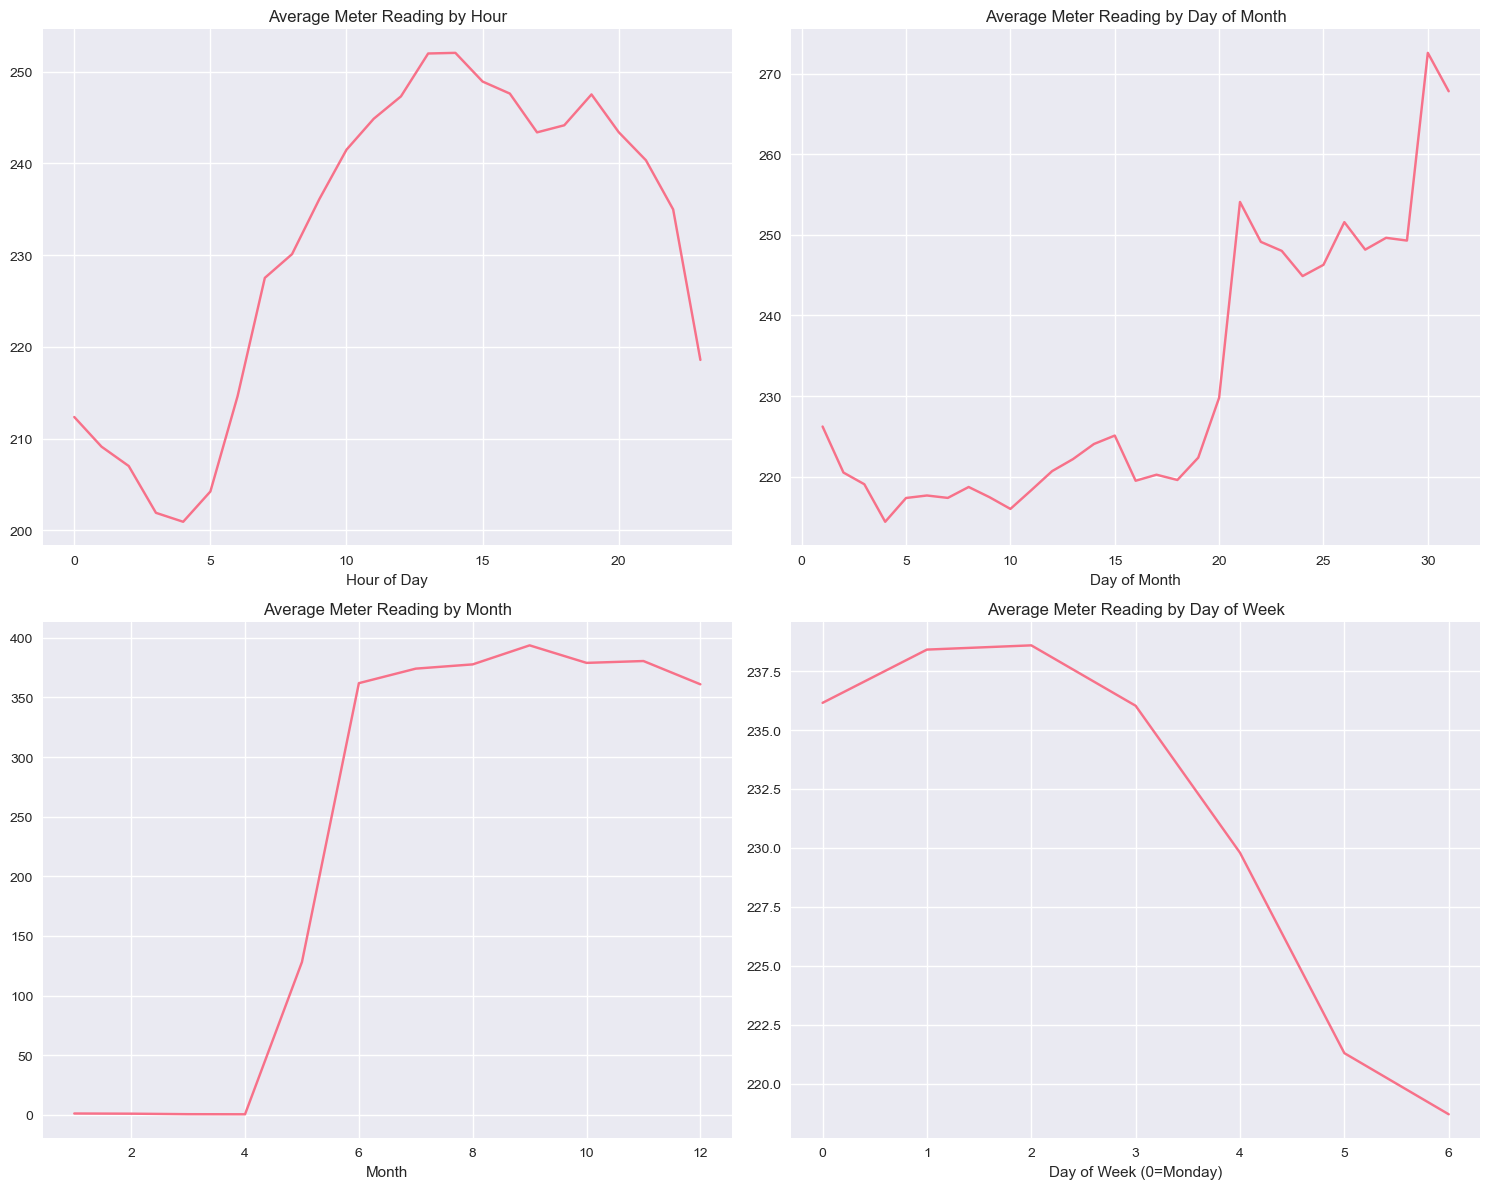

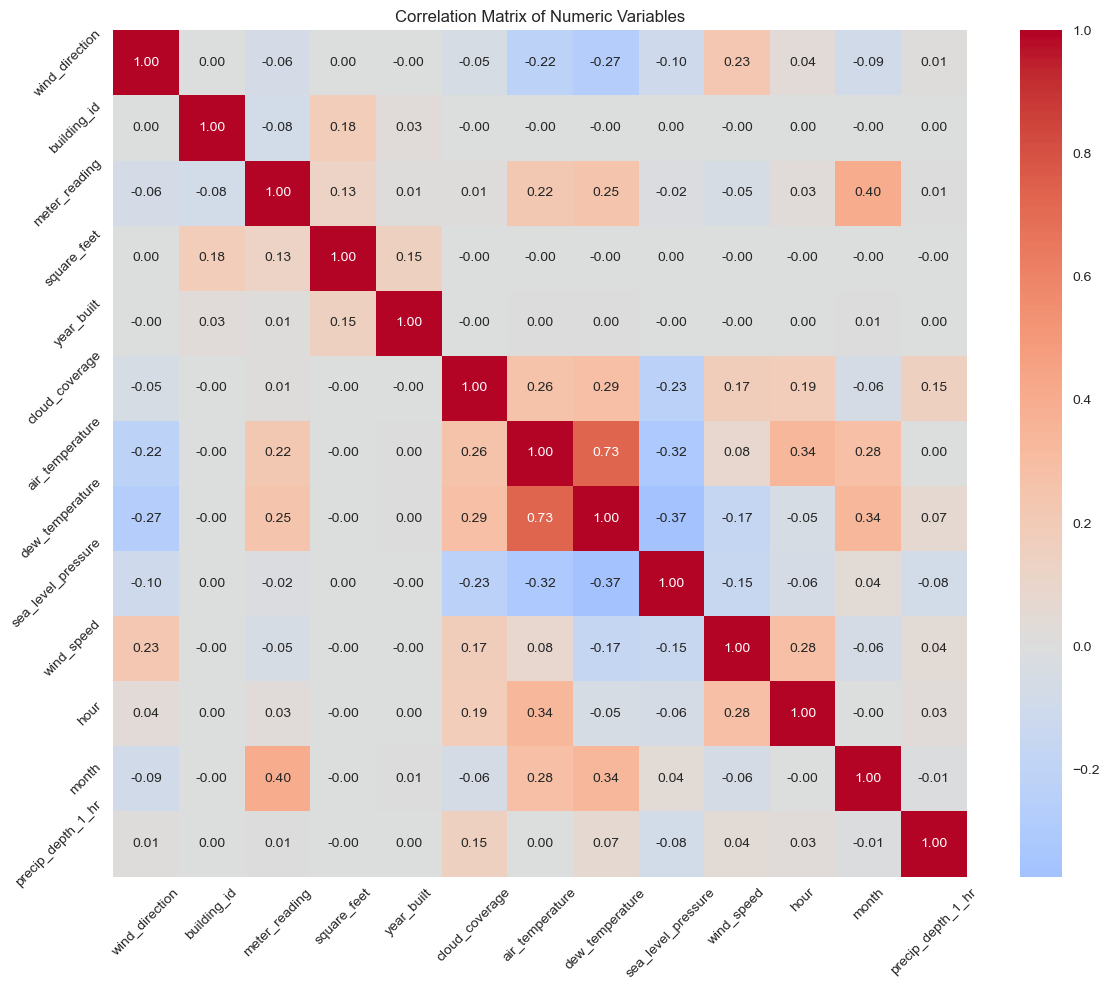

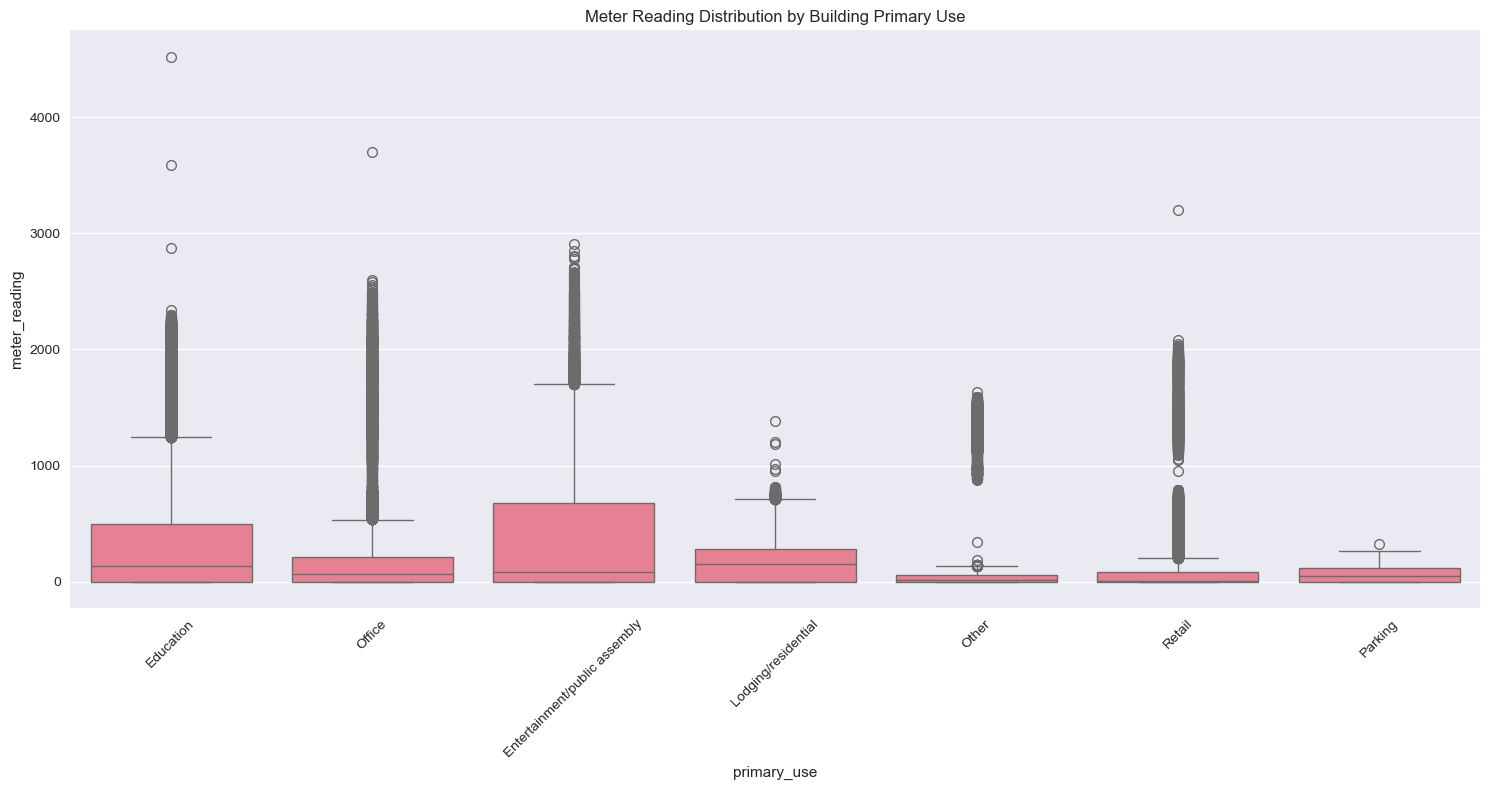

In [18]:
# Visualising all plots

plt.style.use("seaborn-v0_8")
sns.set_palette('husl')

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

df = pd.read_csv('data/train_iterative_imputer_cloud_coverage.csv', parse_dates=['timestamp'])
print(f"Data shape: {df.shape}")

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()


print("\nNumeric columns:")
print(numeric_cols)
print("\nCategorical columns:")
print(categorical_cols)

n_numeric = len(numeric_cols)
rows = (n_numeric + 2) // 3  # 3 columns per row
fig = plt.figure(figsize=(18, 6*rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('./plots/all_plots_1.png')
plt.show()

n_cat = len(categorical_cols)
if n_cat > 0:
    rows = (n_cat + 1) // 2  # 2 columns per row
    fig = plt.figure(figsize=(15, 6*rows))
    
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(rows, 2, i)
        value_counts = df[col].value_counts()
        sns.barplot(x=value_counts.index, y=value_counts.values)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('./plots/all_plots_2.png')
    plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Hourly pattern
df['hour'] = df['timestamp'].dt.hour
hourly_avg = df.groupby('hour')['meter_reading'].mean()
axes[0,0].plot(hourly_avg.index, hourly_avg.values)
axes[0,0].set_title('Average Meter Reading by Hour')
axes[0,0].set_xlabel('Hour of Day')

# Daily pattern
df['day'] = df['timestamp'].dt.day
daily_avg = df.groupby('day')['meter_reading'].mean()
axes[0,1].plot(daily_avg.index, daily_avg.values)
axes[0,1].set_title('Average Meter Reading by Day of Month')
axes[0,1].set_xlabel('Day of Month')

# Monthly pattern
df['month'] = df['timestamp'].dt.month
monthly_avg = df.groupby('month')['meter_reading'].mean()
axes[1,0].plot(monthly_avg.index, monthly_avg.values)
axes[1,0].set_title('Average Meter Reading by Month')
axes[1,0].set_xlabel('Month')

# Day of week pattern
df['dayofweek'] = df['timestamp'].dt.dayofweek
dow_avg = df.groupby('dayofweek')['meter_reading'].mean()
axes[1,1].plot(dow_avg.index, dow_avg.values)
axes[1,1].set_title('Average Meter Reading by Day of Week')
axes[1,1].set_xlabel('Day of Week (0=Monday)')

plt.tight_layout()
plt.savefig('./plots/average_meter_reading.png')
plt.show()

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')
plt.title('Correlation Matrix of Numeric Variables')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
sns.boxplot(data=df, x='primary_use', y='meter_reading')
plt.xticks(rotation=45)
plt.title('Meter Reading Distribution by Building Primary Use')
plt.tight_layout()
plt.savefig('./plots/meter_reading_primary_use.png')
plt.show()

In [19]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import re


# df = df_clean.sort_values(['building_id', 'timestamp'])

# groups = df.groupby(['primary_use', 'building_id'])

# count = 0
# for (usage, bld_id), group_df in groups:
    
#     group_df = group_df.sort_values('timestamp')
#     fig, ax = plt.subplots()

#     ax.plot(group_df['timestamp'], group_df['meter_reading'], label='Meter Reading')

#     ax.set_title(f"Building ID: {bld_id}, Primary Use: {usage}")
#     ax.set_xlabel("Timestamp")
#     ax.set_ylabel("Meter Reading")

#     ax.xaxis.set_major_locator(mdates.MonthLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#     plt.xticks(rotation=45)
#     plt.tight_layout()

#     safe_usage = usage.replace('/', '_')  

#     plt.savefig(f"./building_meter_plots_after_cleaning/building_{bld_id}_{safe_usage}.png", bbox_inches='tight')
#     plt.close()

#     count += 1

# print("Done generating time-series plots.")


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698675 entries, 0 to 698674
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wind_direction      698675 non-null  float64       
 1   building_id         698675 non-null  int64         
 2   timestamp           698675 non-null  datetime64[ns]
 3   meter_reading       698675 non-null  float64       
 4   primary_use         698675 non-null  object        
 5   square_feet         698675 non-null  int64         
 6   year_built          698675 non-null  int64         
 7   cloud_coverage      698675 non-null  float64       
 8   air_temperature     698675 non-null  float64       
 9   dew_temperature     698675 non-null  float64       
 10  sea_level_pressure  698675 non-null  float64       
 11  wind_speed          698675 non-null  float64       
 12  hour                698675 non-null  int32         
 13  month               698675 no

In [21]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
cutoff = pd.Timestamp("2016-05-20 17:00:00")
df_clean = df.loc[df["timestamp"] >= cutoff].copy()
df_clean = df_clean.query("building_id != 53").reset_index(drop=True)

In [22]:
print(f"Rows kept: {len(df_clean):,}  "
      f"({len(df) - len(df_clean):,} dropped)")

Rows kept: 431,001  (267,674 dropped)


In [23]:
df_clean.drop(columns=["day", "dayofweek"], inplace=True)

In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431001 entries, 0 to 431000
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wind_direction      431001 non-null  float64       
 1   building_id         431001 non-null  int64         
 2   timestamp           431001 non-null  datetime64[ns]
 3   meter_reading       431001 non-null  float64       
 4   primary_use         431001 non-null  object        
 5   square_feet         431001 non-null  int64         
 6   year_built          431001 non-null  int64         
 7   cloud_coverage      431001 non-null  float64       
 8   air_temperature     431001 non-null  float64       
 9   dew_temperature     431001 non-null  float64       
 10  sea_level_pressure  431001 non-null  float64       
 11  wind_speed          431001 non-null  float64       
 12  hour                431001 non-null  int32         
 13  month               431001 no

In [25]:
# df_clean.to_csv("data/cleaned_dataset.csv", index=False)

<!-- ## Baseline models -->

#### Traning a lightgbm without any features for baseline

In [26]:
df_clean.columns

Index(['wind_direction', 'building_id', 'timestamp', 'meter_reading',
       'primary_use', 'square_feet', 'year_built', 'cloud_coverage',
       'air_temperature', 'dew_temperature', 'sea_level_pressure',
       'wind_speed', 'hour', 'month', 'precip_depth_1_hr'],
      dtype='object')

In [27]:
train_mask = df_clean.timestamp <  "2016-11-01"
val_mask   = (df_clean.timestamp >= "2016-11-01") & (df_clean.timestamp < "2016-12-01")
test_mask  = df_clean.timestamp >=  "2016-12-01"

df_clean["y_log"] = np.log1p(df_clean["meter_reading"])

num_cols = df_clean.columns.difference(
    ["building_id", "primary_use", "meter_reading", "y_log", "timestamp"]
)
cat_cols_onehot = ["primary_use"]   # one‑hot
cat_cols_lgbm   = ["building_id"]   # leave as category

X_raw = df_clean[num_cols.tolist() + cat_cols_onehot + cat_cols_lgbm].copy()
X_raw["building_id"] = X_raw["building_id"].astype("category")

y_raw = df_clean["y_log"].values

X_train_raw, y_train = X_raw[train_mask], y_raw[train_mask]
X_val_raw,   y_val   = X_raw[val_mask],   y_raw[val_mask]
X_test_raw,  y_test  = X_raw[test_mask],  y_raw[test_mask]

pre = ColumnTransformer(
    [("onehot", OneHotEncoder(handle_unknown="ignore"), cat_cols_onehot)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

X_train = pre.fit_transform(X_train_raw)
X_val   = pre.transform(X_val_raw)
X_test  = pre.transform(X_test_raw)



In [28]:
lgbm = lgb.LGBMRegressor(
    objective          = "tweedie",
    tweedie_variance_power = 1.1,     # 1.0 ≈ Poisson, 2.0 ≈ Gamma – 1.1 works well for energy
    n_estimators       = 10000,      
    learning_rate      = 0.03,
    num_leaves         = 512,
    feature_fraction   = 0.85,
    bagging_fraction   = 0.85,
    bagging_freq       = 5,
    min_data_in_leaf   = 50,
    random_state       = 42,
    metric             = "rmse",     
)

print("Training baseline LightGBM …")
lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=2000, verbose=False),
        log_evaluation(period=200),
    ],
)

print(f"\nBest iteration              : {lgbm.best_iteration_}")
print(f"Validation RMSE (log‑space) : {lgbm.best_score_['valid_0']['rmse']:.5f}")

y_hat_test_log = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)
rmse_kwh = np.sqrt(((np.expm1(y_hat_test_log) - np.expm1(y_test))**2).mean())
print(f"Test RMSE (kWh)             : {rmse_kwh:.2f}")


Training baseline LightGBM …
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Aut

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "seed": 42,
    "tree_method": "hist",
}

print("Training baseline XGBoost …")
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dval, "val")],
    early_stopping_rounds=200,
    verbose_eval=200,
)

best_iter = bst.best_iteration
val_rmse_log = bst.best_score
print(f"\nBest iteration              : {best_iter}")
print(f"Validation RMSE (log‑space) : {val_rmse_log:.5f}")

y_hat_test_log = bst.predict(dtest)
rmse_kwh = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_hat_test_log)))
print(f"Test RMSE (kWh)             : {rmse_kwh:.2f}")

Training baseline XGBoost …
[0]	val-rmse:1.31420
[200]	val-rmse:0.36148
[400]	val-rmse:0.35664
[600]	val-rmse:0.35766
[670]	val-rmse:0.35824

Best iteration              : 470
Validation RMSE (log‑space) : 0.35548
Test RMSE (kWh)             : 116.65


### Hyperparameter tuned XGBoost

In [ ]:
from itertools import product
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

grid = {
    "n_estimators":     [300, 600, 1200],
    "learning_rate":    [0.03, 0.1],
    "max_depth":        [4, 6, 8],
    "subsample":        [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}
keys, values = zip(*grid.items())
param_sets = [dict(zip(keys, v)) for v in product(*values)]

best_params, best_rmse = None, float("inf")

for params in param_sets:
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist",
        **params
    )
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    val_rmse = rmse(y_val, val_pred)        # log‑space RMSE

    print("params", params, " -> val_RMSE_log {:.5f}".format(val_rmse))

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_params = params

print("\nBest log-space RMSE on Validation Set :", "%.5f" % best_rmse)
print("Best params :", best_params)

X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

final_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist",
    **best_params
)
final_model.fit(X_trainval, y_trainval)

test_pred_log = final_model.predict(X_test)


params {'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.8}  -> val_RMSE_log 0.43933
params {'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 1.0}  -> val_RMSE_log 0.43826
params {'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 4, 'subsample': 1.0, 'colsample_bytree': 0.8}  -> val_RMSE_log 0.44309
params {'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 4, 'subsample': 1.0, 'colsample_bytree': 1.0}  -> val_RMSE_log 0.44797
params {'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8}  -> val_RMSE_log 0.37665
params {'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 1.0}  -> val_RMSE_log 0.37464
params {'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 6, 'subsample': 1.0, 'colsample_bytree': 0.8}  -> val_RMSE_log 0.37659
params {'n_estimators': 300, 'learning_rate': 0.

In [ ]:
test_rmse_kwh = rmse(np.expm1(y_test), np.expm1(test_pred_log))
print("test RMSE (kWh): {:.2f}".format(test_rmse_kwh))


test RMSE (kWh): 95.79


## plotting y_log and meter_reading for sanity check before creating features for training ML Models

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431001 entries, 0 to 431000
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wind_direction      431001 non-null  float64       
 1   building_id         431001 non-null  int64         
 2   timestamp           431001 non-null  datetime64[ns]
 3   meter_reading       431001 non-null  float64       
 4   primary_use         431001 non-null  object        
 5   square_feet         431001 non-null  int64         
 6   year_built          431001 non-null  int64         
 7   cloud_coverage      431001 non-null  float64       
 8   air_temperature     431001 non-null  float64       
 9   dew_temperature     431001 non-null  float64       
 10  sea_level_pressure  431001 non-null  float64       
 11  wind_speed          431001 non-null  float64       
 12  hour                431001 non-null  int32         
 13  month               431001 no

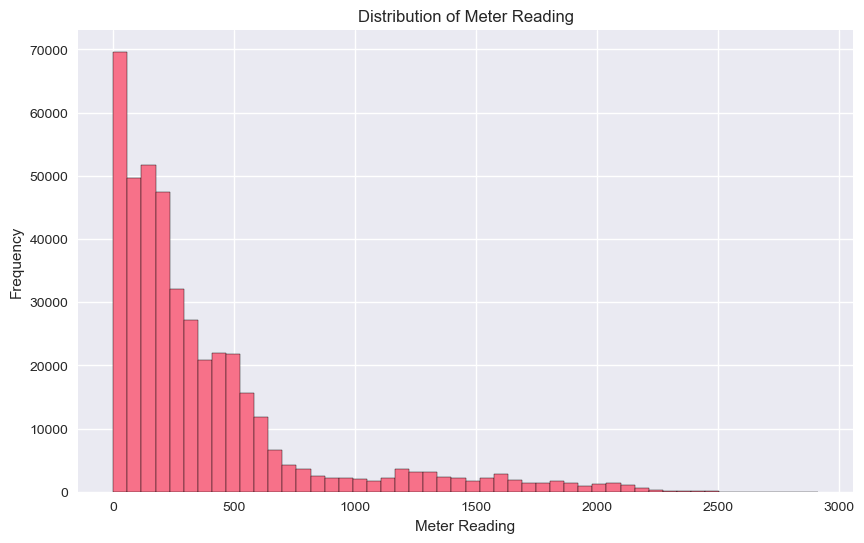

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['meter_reading'], bins=50, edgecolor='black')
plt.title('Distribution of Meter Reading')
plt.xlabel('Meter Reading')
plt.ylabel('Frequency')
plt.show()

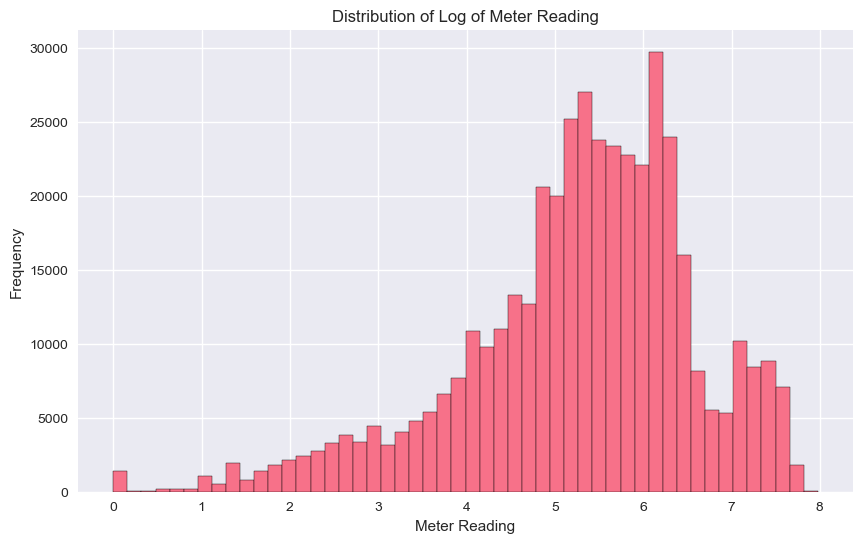

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['y_log'], bins=50, edgecolor='black')
plt.title('Distribution of Log of Meter Reading')
plt.xlabel('Meter Reading')
plt.ylabel('Frequency')
plt.show()